# Data Explorer

<a href="https://colab.research.google.com/github/neurologic/Neurophysiology-Lab/blob/main/modules/eod/Data-Explorer_eod.ipynb" target="_blank"><img alt="Open In Colab" src="https://colab.research.google.com/assets/colab-badge.svg"/></a>   

<a id="toc"></a>
# Table of Contents

- [Introduction](#intro)
- [Setup](#setup)
- [Part I. Event detection](#one)
- Time series analyses:
    - [Part II. Rate](#two)
    - [Part III. ISI](#three)
    - [Part IV. Filtered](#four)
- [Part V. Sampling Rate](#five)

<a id="intro"></a>
# Electric Organ Discharge

Weakly electric fish essentially have a battery in their tail. It is made of modified muscle fibers, which means that it is innervated by motor neurons. Acetylcholine is released at this neuro-electric junction and, in response, the modified muscle fibers become polarized in parallel to produce a dipole-like electric field source. 

<div align="center">
<figure>
<img src='https://github.com/neurologic/Neurophysiology-Lab/blob/main/images/weakly-electric-fish-efield-current_Kramer.jpeg?raw=True' width="500" align="center" alt='eod e-field'/>
</figure>
</div>

Therefore, when you place a pair of electrodes in the water near the fish, you can measure the voltage produced by the fish. Different species of fish polarize their batteries (the *electric organ*) with different timecourses. In other words, across time, the polarization waveform is *species-specific*.  

<div align="center">
<figure>
<img src='https://github.com/neurologic/Neurophysiology-Lab/blob/main/images/example-eods_Kramer.jpeg?raw=True' width="300" alt='eod e-field' align="center"/>
<figcaption align = "center"><b>Electric organ discharge (EDO) waveform</b> in three snoutfish species of southern Africa across sexes. All EODs are plotted as voltage over time, recorded immediately after capture. Same time bar for all. (a) Sexual dimorphism in Marcusenius altisambesi with two distinct waveforms. (b) Sex difference of only a statistical nature in Petrocephalus catostoma (Upper Zambezi form) with, in most males, a stronger second positive phase than in females, such as shown here. (c) Petrocephalus wesselsi (Sabie River, South Africa) with no difference between the sexes. P. wesselsi was recognized as distinct from P. catostoma only recently.
</figcaption>
</figure>
</div>


Weakly electric fish use the electric field generated by their pulse-like *electric organ discharges* (EODs) to communicate with each other (*electrocommunication* and to sense the physical environment around them (via distortions of the electric field cause by the physical environment; *electrolocation*). 

<div align="center">
<figure>
<img src='https://github.com/neurologic/Neurophysiology-Lab/blob/main/images/weakly-electric-fish-Efields-locate-communicate.jpeg?raw=True' width="600" alt='eod e-field'/>
</figure>
</div>

<a id="setup"></a>
# Setup

In [ ]:
#@title {display-mode: "form" }

from jupyter_dash import JupyterDash
import dash_cytoscape as cyto  # pip install dash-cytoscape==0.2.0 or higher
# import dash_html_components as html (package is deprecated)
# import dash_core_components as dcc (package is deprecated)
from dash import html, dcc

from dash.dependencies import Output, Input
import pandas as pd  # pip install pandas
import plotly.express as px
import math
from dash import no_update



In [ ]:
external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']
app = JupyterDash(__name__, external_stylesheets=external_stylesheets)

df = pd.read_csv("https://raw.githubusercontent.com/Coding-with-Adam/Dash-by-Plotly/master/Cytoscape/org-data.csv")

app.layout = html.Div([
    html.Div([
        dcc.Dropdown(
            id='dpdn',
            value='breadthfirst',
            clearable=False,
            options=[
                {'label': name.capitalize(), 'value': name}
                for name in ['breadthfirst' ,'grid', 'random', 'circle', 'cose', 'concentric']
            ]
        ),
        cyto.Cytoscape(
            id='org-chart',
            autoungrabify=True,
            minZoom=0.2,
            maxZoom=1,
            layout={'name': 'breadthfirst'},
            style={'width': '100%', 'height': '500px'},
            elements=
                [
                    # Nodes elements
                    {'data': {'id': x, 'label': x}} for x in df.name
                ]
                +
                [
                    # Edge elements
                    {'data': {'source': 'Executive Director (Harriet)', 'target': 'Vice President (Sarah)'}},
                    {'data': {'source': 'Executive Director (Harriet)', 'target': 'Vice President (Charlotte)'}},
                    {'data': {'source': 'Vice President (Sarah)', 'target': 'Program Officer (Sojourner)'}},
                    {'data': {'source': 'Vice President (Sarah)', 'target': 'Program Officer (Elizabeth)'}},
                    {'data': {'source': 'Vice President (Charlotte)', 'target': 'Program Associate (Ellen)'}},
                ]
        )
    ], className='six columns'),

    html.Div([
        html.Div(id='empty-div', children='')
    ],className='one column'),

    html.Div([
        dcc.Graph(id='my-graph', figure=px.bar(df, x='name', y='slaves_freed'))
    ], className='five columns'),

], className='row')


@app.callback(Output('org-chart', 'layout'),
              Input('dpdn', 'value'))
def update_layout(layout_value):
    if layout_value == 'breadthfirst':
        return {
        'name': layout_value,
        'roots': '[id = "Executive Director (Harriet)"]',
        'animate': True
        }
    else:
        return {
            'name': layout_value,
            'animate': True
        }


@app.callback(
    Output('my-graph','figure'),
    Input('org-chart','tapNodeData'),
)
def update_nodes(data):
    if data is None:
        return no_update
    else:
        dff = df.copy()
        dff.loc[dff.name == data['label'], 'color'] = "yellow"
        fig = px.bar(dff, x='name', y='slaves_freed')
        fig.update_traces(marker={'color': dff['color']})
        return fig


app.run_server(mode='inline', port=8030)

Import and define functions

In [ ]:
#@title {display-mode: "form" }

#@markdown Run this code cell to import packages and define functions 
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy import ndimage
from scipy.signal import hilbert,medfilt,resample, find_peaks, unit_impulse
import seaborn as sns
from datetime import datetime,timezone,timedelta
pal = sns.color_palette(n_colors=15)
pal = pal.as_hex()
import matplotlib.pyplot as plt
import random

from pathlib import Path

from ipywidgets import interactive, HBox, VBox, widgets, interact

print('Task completed at ' + str(datetime.now(timezone(-timedelta(hours=5)))))

Mount Google Drive

In [ ]:
#@title {display-mode: "form" }

#@markdown Run this cell to mount your Google Drive.

from google.colab import drive
drive.mount('/content/drive')

print('Task completed at ' + str(datetime.now(timezone(-timedelta(hours=5)))))

Import data digitized with *Nidaq USB6211* and recorded using *Bonsai-rx* as a *.bin* file

In [ ]:
#@title {display-mode: "form" }

#@markdown Specify the file path 
#@markdown to your recorded data on Drive (find the filepath in the colab file manager:

filepath = "full filepath goes here"  #@param 
filepath = '/Users/kperks/Downloads/eod-50k-stim2022-08-17T14_50_39.bin'

#@markdown Specify the sampling rate and number of channels recorded.

# sampling_rate = None #@param
# number_channels = None #@param

# downsample = False #@param
# newfs = 10000 #@param

sampling_rate = 50000 #@param
number_channels = 2 #@param

downsample = False #@param
newfs = 10000 #@param

#@markdown After you have filled out all form fields, 
#@markdown run this code cell to load the data. 

filepath = Path(filepath)

# No need to edit below this line
#################################
data = np.fromfile(Path(filepath), dtype = np.float64)
data = data.reshape(-1,number_channels)
data_dur = np.shape(data)[0]/sampling_rate
print('duration of recording was %0.2f seconds' %data_dur)

fs = sampling_rate
if downsample:
    # newfs = 10000 #downsample emg data
    chunksize = int(sampling_rate/newfs)
    data = data[0::chunksize,:]
    fs = int(np.shape(data)[0]/data_dur)

time = np.linspace(0,data_dur,np.shape(data)[0])

print('Data upload completed at ' + str(datetime.now(timezone(-timedelta(hours=5)))))

In [ ]:
np.arange(number_channels)

In [ ]:
# Step 1. Launch the application
# app = dash.Dash()
app = JupyterDash()

# Step 2. Import data

# Step 3. Create a plotly figure

layout=go.Layout(height=500, width=800)

fig = go.Figure(layout = layout)
# f = go.FigureWidget(layout=go.Layout(height=500, width=800))
for chan in np.arange(number_channels):
    fig.add_trace(go.Scatter(x = time[0:fs], y = data[0:fs,chan],
                         name=str(chan),opacity=1))





# Step 4. Create a Dash layout
app.layout = html.Div([
                # a header and a paragraph
                html.Div([
                    html.H2("Raw Data Explorer"),
                    html.P("You can: Use the range slider below the plot to navigate through the recording. \
                    Zoom in and out on detail in the signal. Hover over the signal to annotate data points. \
                    Move the graph around if you are zoomed in. Save a png. ")
                         ],
                     style = {'padding' : '5px' ,
                              'backgroundColor' : '#3aaab2'}),
                # adding a plot
                dcc.Graph(id = 'plot', figure = fig),
                # # dropdown
                # html.P([
                #     html.Label("Choose a channel"),
                #     dcc.Dropdown(id = 'opt', options = opts,
                #                 value = opts[0])
                #         ], style = {'width': '400px',
                #                     'fontSize' : '20px',
                #                     'padding-left' : '100px',
                #                     'display': 'inline-block'}),
                # range slider
                html.P([
                    html.Label("Time Period (seconds)"),
                    dcc.RangeSlider(id = 'slider',
                                    min = 0,
                                    max = data_dur,
                                    value = [0, 1])
                        ], style = {'width' : '100%',
                                    'fontSize' : '15px',
                                    'display': 'inline-block'})
                      ])


# Step 5. Add callback functions
@app.callback(Output('plot', 'figure'),
             [Input('slider', 'value')])
def update_figure(input1):
    # filtering the data
    starti = int(input1[0]*fs)
    stopi = int(input1[1]*fs)
        
    # updating the plot
    chan = 0
    fig = go.Figure(layout = layout)
    
    for chan in np.arange(number_channels):
        fig.add_trace(go.Scatter(x = time[starti:stopi], y = data[starti:stopi,chan],
                         name=str(chan),opacity=1))
    # trace_1 = go.Scatter(x = time[starti:stopi], y = data[starti:stopi,chan],
    #                     name = str(chan))

    return fig
  
# Step 6. Add the server clause
# if __name__ == '__main__':
#     app.run_server(debug = True)
app.run_server(mode='inline')

In [32]:
int(100*fs)

1000

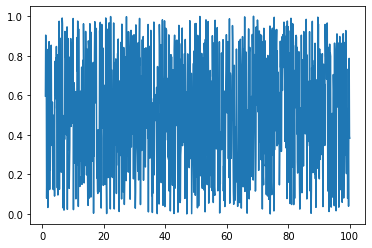

In [31]:

fs = 10
time = np.linspace(1,100,int(100*fs))
data = np.random.rand(int(100*fs)).reshape(-1,1)
plt.plot(time,data);

In [33]:
fs = 10
data_dur = 100
time = np.linspace(1,data_dur,int(data_dur*fs))
data = np.random.rand(int(data_dur*fs)).reshape(-1,1)
# plt.plot(time,data);


number_channels = 1

# Step 1. Launch the application

app = JupyterDash()

# Step 2. Import data

# Step 3. Create a plotly figure

layout=go.Layout(height=500, width=800)

fig = go.Figure(layout = layout)
# f = go.FigureWidget(layout=go.Layout(height=500, width=800))
for chan in np.arange(number_channels):
    fig.add_trace(go.Scatter(x = time[0:fs], y = data[0:fs,chan],
                         name=str(chan),opacity=1))





# Step 4. Create a Dash layout
app.layout = html.Div([
                # a header and a paragraph
                html.Div([
                    html.H2("Raw Data Explorer"),
                    html.P("You can: Use the range slider below the plot to navigate through the recording. \
                    Zoom in and out on detail in the signal. Hover over the signal to annotate data points. \
                    Move the graph around if you are zoomed in. Save a png. ")
                         ],
                     style = {'padding' : '5px' ,
                              'backgroundColor' : '#3aaab2'}),
                # adding a plot
                dcc.Graph(id = 'plot', figure = fig),
                # # dropdown
                # html.P([
                #     html.Label("Choose a channel"),
                #     dcc.Dropdown(id = 'opt', options = opts,
                #                 value = opts[0])
                #         ], style = {'width': '400px',
                #                     'fontSize' : '20px',
                #                     'padding-left' : '100px',
                #                     'display': 'inline-block'}),
                # range slider
                html.P([
                    html.Label("Time Period (seconds)"),
                    dcc.RangeSlider(id = 'slider',
                                    min = 0,
                                    max = data_dur,
                                    value = [0, 1])
                        ], style = {'width' : '100%',
                                    'fontSize' : '15px',
                                    'display': 'inline-block'})
                      ])


# Step 5. Add callback functions
@app.callback(Output('plot', 'figure'),
             [Input('slider', 'value')])
def update_figure(input1):
    # filtering the data
    starti = int(input1[0]*fs)
    stopi = int(input1[1]*fs)
        
    # updating the plot
    chan = 0
    fig = go.Figure(layout = layout)
    
    for chan in np.arange(number_channels):
        fig.add_trace(go.Scatter(x = time[starti:stopi], y = data[starti:stopi,chan],
                         name=str(chan),opacity=1))
    # trace_1 = go.Scatter(x = time[starti:stopi], y = data[starti:stopi,chan],
    #                     name = str(chan))

    return fig
  
# Step 6. Add the server clause
# if __name__ == '__main__':
#     app.run_server(debug = True)
app.run_server(mode='inline')

In [ ]:
#@title {display-mode: "form"}

#@markdown Run this code cell to plot imported data. <br> 
#@markdown Use the range slider under the plot to scroll through the data in time.
#@markdown > NOTE: Do not plot too large of a time window at once... it will slow down the plot and/or bork

f = go.FigureWidget(layout=go.Layout(height=500, width=800))
for i,chan in enumerate(range(number_channels)):
  f.add_trace(go.Scatter(x = time[0:fs], y = data[0:fs,chan],
                         name=str(chan),opacity=1))

slider = widgets.FloatRangeSlider(
    min=0,
    max=data_dur,
    value=(0,1),
    step= 1,
    readout=False,
    description='Time')
slider.layout.width = '800px'

# our function that will modify the xaxis range
def response(x):
    with f.batch_update():
        starti = int(x[0]*fs)
        stopi = int(x[1]*fs)

        for i in range(number_channels):
            f.data[i].x = time[starti:stopi]
            f.data[i].y = data[starti:stopi,i]

vb = VBox((f, interactive(response, x=slider)))
vb.layout.align_items = 'center'
vb

<a id="one"></a>
# Part I. Event Detection

Python has built-in algorithms for detecting "peaks" in a signal. However, it will detect *all* peaks. Therefore, the function takes in arguments that specify parameters for minimum height that can count as a peak and a minimum acceptible interval between independent peaks. 

First, we will subtract the median of the signal, take the absolute value of the signal, and sum across all channels (if you recorded more than one). With this single combined signal, we will detect peaks. 

In [ ]:
#@title {display-mode: "form"}

#@markdown Run this code cell to plot the combined signal for peak detection. 
#@markdown Use the plot to determine an appropriate detection threshold.

y = data - np.median(data)
y = np.sum(np.abs(y),1)

f = go.FigureWidget(layout=go.Layout(height=500, width=800))
f.add_trace(go.Scatter(x = time[0:fs], y = y[0:fs],
                         name='summed signal',opacity=1))

slider = widgets.FloatRangeSlider(
    min=0,
    max=data_dur,
    value=(0,1),
    step= 1,
    readout=False,
    description='Time')
slider.layout.width = '800px'

# our function that will modify the xaxis range
def response(x):
    with f.batch_update():
        starti = int(x[0]*fs)
        stopi = int(x[1]*fs)

        f.data[0].x = time[starti:stopi]
        f.data[0].y = y[starti:stopi]

vb = VBox((f, interactive(response, x=slider)))
vb.layout.align_items = 'center'
vb

In [ ]:
#@title {display-mode: "form"}

#@markdown Fill in this form with the detection threshold. 

detection_threshold = None #@param
detection_threshold = 0.05 #@param
#@markdown Then run the code cell to detect peaks (events)

y = data - np.median(data)
y = np.sum(np.abs(y),1)

d = 0.0003*fs #minimum time allowed between distinct events
r = find_peaks(y,height=detection_threshold,distance=d)

eod_times = r[0]/fs

In [ ]:
#@title {display-mode: "form"}

#@markdown Run this code cell to plot the signal on each trial 
#@markdown overlaid with a scatter of EOD times detected using your threshold. 
#@markdown > NOTE: Do not plot too large of a time window at once... it will slow down the plot and/or bork

f = go.FigureWidget()

for i,chan in enumerate(range(number_channels)):
    f.add_trace(go.Scatter(x = time[0:fs], y = data[0:fs,chan],
                         name=str(chan),opacity=1))
f.add_trace(go.Scatter(x = eod_times[(eod_times>0) & (eod_times<1)],
                       mode = "markers", marker=dict( color='black')))
    
slider = widgets.FloatRangeSlider(
    min=0,
    max=data_dur,
    value=(0,1),
    step= 1,
    readout=False,
    description='Time')
slider.layout.width = '800px'

# our function that will modify the xaxis range
def response(x):
    with f.batch_update():
        starti = int(x[0]*fs)
        stopi = int(x[1]*fs)

        for i in range(number_channels):
            f.data[i].x = time[starti:stopi]
            f.data[i].y = data[starti:stopi,i]
        f.data[number_channels].x = eod_times[(eod_times>x[0]) & (eod_times<x[1])]
        f.data[number_channels].y = [np.median(data)] * len(eod_times[(eod_times>x[0]) & (eod_times<x[1])])

vb = VBox((f, interactive(response, x=slider)))
vb.layout.align_items = 'center'
vb

Once you know the times of each peak (each event), we can look at the waveforms of those events. To do this, we plot the peak of the signal at the event time and some duration before and after that peak. 

> Note: If you do not think you are detecting enough of the events or if you think you are detecting too much noise, modify your detection threshold and go through the detection steps in Part I again.

In [ ]:
#@title {display-mode: "form"}

#@markdown Select a pre and post event duration (dur; in milliseconds) to plot for each EOD.
dur = 0.3 #@param

#@markdown Set the y-axis range based on your raw data.
ymin = -0.3
ymax = 0.1

#@markdown Then run this cell to create an interactive plot with a slider to scroll through EOD events and channels.
win = int(dur/1000*fs)

# Create plotly widget plot
f = go.FigureWidget(layout=go.Layout(height=600, width=600), layout_yaxis_range=[ymin,ymax])

eodi = 0
chan = 0

events = np.asarray([data[(int(fs*t)-win):(int(fs*t)+win),chan] for t in eod_times 
          if (((int(fs*t)-win)>0) & ((int(fs*t)+win)<np.shape(data)[0]))]).T

etime = np.linspace(-0.0003,0.0003,np.shape(events)[0])
f.add_trace(go.Scatter(x = etime, y = events[:,eodi],
                         name='EOD #' + str(i),opacity=1))
    
slider_eod = widgets.IntSlider(
    min=0,
    max=np.shape(events)[1],
    value=0,
    step= 1,
    description='EOD number')
slider_eod.layout.width = '800px'

slider_chan = widgets.IntSlider(
    min=0,
    max=number_channels-1,
    value=0,
    step= 1,
    description='channel')
slider_chan.layout.width = '400px'

# our function that will modify the xaxis range
def response(eodi,chan):
    events = np.asarray([data[(int(fs*t)-win):(int(fs*t)+win),chan] for t in eod_times 
          if (((int(fs*t)-win)>0) & ((int(fs*t)+win)<np.shape(data)[0]))]).T
    f.data[0].y = events[:,eodi]

vb = VBox((f, interactive(response, eodi=slider_eod, chan=slider_chan)))
vb.layout.align_items = 'center'
vb

Take some time to explore and observe the variation in EOD waveforms. 

There are a fundamental set of processing techniques we use to quantify event time series (such as spikes from a neuron or EODs from a fish): rate, isi, filtered/smoothed. In Part II - Part IV, you will work with each of these analyses.

<a id="two"></a>
# Part II. Rate

## Average rate

How would you calculate the average event rate?

<div class="alert-info">
<b>Tip:</b>
    <li> <b>len(variable)</b> : len() is a function used to get the number of elements in an array called *variable*</li>
    <li> the time of the first and last event are simply the event times</li>
    <li> <code class="lang-python">+ - * / </code> are the symbols for addition, subtraction, multiplication, and division</li>
    <li><b>eod_times</b> is a variable that contains the list of EOD times</li>
</div>

In the code cell below, write code that would calculate the average EOD rate in your recording. Store the result as a variable called ```average_rate```. 

In [ ]:
...

In [ ]:
#@title {display-mode:"form"}

#@markdown Run this code cell to print the result of your average rate calculation. 
print(f'The average EOD rate is {average_rate}')

## Subsampling (*bootstrapping*) the average rate

In order to do statistics and compare EOD rates between different conditions or groups (for example, among different species of fish), we need more than just one estimate of the EOD rate. 

*bootstrapping* is an analytic technique used to *subsample* your data. In this case, we will calculate a set of EOD rate averages. Then we can get the mean and standard deviation of the average EOD rate. A *subsample* of the data is a smaller continuous section of the data. 

You can control the number of subsampled sets and the duration of each set. 
The script (hidden) in the code cell below randomly selects samples of the specified duration from throughout the total recording. It repeats this random selection process ***N*** times. 

Once you specify the bootstrapping parameters in the form below, run the code cell. You will see a plot of the average rate of each subsample (each black point in the scatterplot), and the distribution (quantiles) of the set of subsamples in boxplot format.

In [ ]:
#@title {display-mode: "form"}

#@markdown Specify a duration time to subsample and a number of times to sample. 
#@markdown The duration should be at least half the duration of your recording. 
#@markdown See what changing these parameters does to your result.
#@markdown > NOTE: duration is in seconds

duration = None #@param
N = None #@param

rate_ = []
for i in range(N):
    t = random.uniform(np.min(eod_times)+duration,np.max(eod_times)-duration)
    rate_.append(sum((eod_times>t) & (eod_times<t+duration))/duration)

plt.figure(figsize=(3,5));
sns.boxplot(y=rate_, color = 'grey');
sns.stripplot(y = rate_, color = 'black',size=10);
plt.ylabel('rate',fontsize=14);
plt.yticks(fontsize=14);

If you increase/decrease the duration of the subsampled data, does the variance of the estimated rate increase/decrease?

If you decrease/increase N, does the distribution of the estimate change? How?

## Variability in EOD rate

Variance, Standard Deviation
Histogram

In [ ]:
variability_std = np.std(np.diff(eod_times))
print(f"Standard Deviation of rate (1/time between each pair of pulses) = {variability_std}")

# plot histogram

<a id="three"></a>
# Part III. ISI

The time between events is called the *inter-event interval". Since events in neurons are called *spikes* the metric is called an *inter-SPIKE interval* (***ISI***). In electric fish, the metric is also called the IPI (inter-*pulse* interval), which refers to each EOD event as a pulse. 

How would you calculate the ISI from your recording?

<div class="alert-info">
<b>Tip:</b> 
    <li> <b>np.diff(variable)</b> : *diff()* is <a href="https://numpy.org/doc/stable/reference/generated/numpy.diff.html">a numpy module</a> that calculates the numerical difference between each element in a list named <i>variable</i> and returns the result as a list</li>
    <li><b>eod_times</b> is a variable that contains the list of EOD times</li>
</div>

In the code cell below, write a script that performs this calculation. 
Store the result as a variable called ```isi```


In [ ]:
isi = ...

In [ ]:
#@title {display-mode: "form"}

#@markdown Run this code cell to calculate the average isi and plot the isi over time. 

print(f'Average isi is {np.mean(isi):0.2f}.')

# plot the isi at each EOD time.
fig = go.Figure(layout=go.Layout(height=500, width=800))
fig.add_trace(go.Scatter(x=eod_times[1:], y=isi, mode='markers',name='isi',marker_size=5,line_color='black'))

fig.show()

What should the titles of the x and y axes be?

How does the isi relate to the rate? How would you calculate *instantaneous* rate (as opposed to the average rate across some window of time)?

In [ ]:
#@title {display-mode:"form"}

#@markdown Run this code cell to plot the isi distribution (in boxplot format)

plt.figure(figsize=(3,5));
sns.boxplot(y=isi, color = 'grey');
# sns.stripplot(y = isi, color = 'black',size=10);
plt.ylabel('isi',fontsize=14);
plt.yticks(fontsize=14);

<a id="four"></a>
# Part IV. Filtered

By *convolving* a waveform with a time series, each event is transformed into a waveform. When all of these event waveforms are added together, you get a continuous signal instead of a discrete time series. This transformation is sometimes called "smoothing" and is required before some calculations can be made (such as correlation analysis). 

In [ ]:
#@title {display-mode: "form"}

#@markdown Choose a smoothing filter width ```sigma``` (the standard deviation of the *gaussian kernel* in seconds). <br>
#@markdown Then run this code cell to plot the smoothed signal from discrete EOD times. 

sigma = 0.1 #@param

filtered_fs = 1000

sigma = sigma*filtered_fs

eod_samps = [int(t*filtered_fs) for t in eod_times]

filtered_time = np.linspace(0,data_dur,int(data_dur*filtered_fs))
filtered_y = unit_impulse(len(filtered_time),eod_samps)
filtered_y = ndimage.gaussian_filter1d(filtered_y,sigma)*filtered_fs

# Create plotly widget plot
f = go.FigureWidget(layout=go.Layout(height=500, width=800), layout_yaxis_range=[np.min(filtered_y),np.max(filtered_y)])

i = 0
f.add_trace(go.Scatter(x = filtered_time, y = filtered_y,
                         name='smoothed EOD times',opacity=1,line_color='black',mode='lines'))
    
slider = widgets.FloatRangeSlider(
    min=0,
    max=data_dur,
    value=(0,1),
    step= 1,
    readout=False,
    description='Time')
slider.layout.width = '800px'

# our function that will modify the xaxis range
def response(x):
    with f.batch_update():
        starti = int(x[0]*filtered_fs)
        stopi = int(x[1]*filtered_fs)

        f.data[0].x = filtered_time[starti:stopi]
        f.data[0].y = filtered_y[starti:stopi]
            
vb = VBox((f, interactive(response, x=slider)))
vb.layout.align_items = 'center'
vb

## simple plot
# plt.figure()
# plt.plot(filtered_time,ndimage.gaussian_filter1d(filtered_y,10,axis=0)*filtered_fs)
# plt.xlim(0,4)
# plt.scatter(eod_times[1:],1/np.diff(eod_times))

## simple plotly
# plot the isi at each EOD time.
# f = go.Figure(layout=go.Layout(height=500, width=800))
# f.add_trace(go.Scatter(x=filtered_time, y=filtered_y, mode='lines',name='filtered EOD times',line_color='black'))
# f



<a id="five"></a>
# Part V. Sampling Rate

In terms of electrophysiology data acquisition, sampling rate is the rate at which analog signals in the world are digitized and sent to the computer. The sampling rate that you choose impacts the size of data files as well as the resolution of the digitized signal. 

Using the plots generated in Part I, compare EOD waveforms (from the same species) sampled with different sampling rates. 

<hr> 
Written by Dr. Krista Perks for courses taught at Wesleyan University.